In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from mpl_toolkits import mplot3d
from scipy.spatial.distance import cdist

In [2]:
np.random.seed(35)

# Introduction
This notebook is an exercise in customer segmentation, a very common application of the KMeans clustering algorithm. We will develop the KMeans algorithm from scratch using Numpy and segment the customers into groups based on Age, Annual Income, and Spending Score.

In [3]:
customer_data = pd.read_csv("Mall_Customers.csv")
print(customer_data.head())

   CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male   19                  15                      39
1           2    Male   21                  15                      81
2           3  Female   20                  16                       6
3           4  Female   23                  16                      77
4           5  Female   31                  17                      40


# EDA
First, some Exploratory Data Analysis. It's very important to understand your features before applying machine learning techniques! 

In [4]:
gender_map = {"Male":1, "Female":0}
customer_data["Gender"] = customer_data["Gender"].apply(lambda x: gender_map[x])

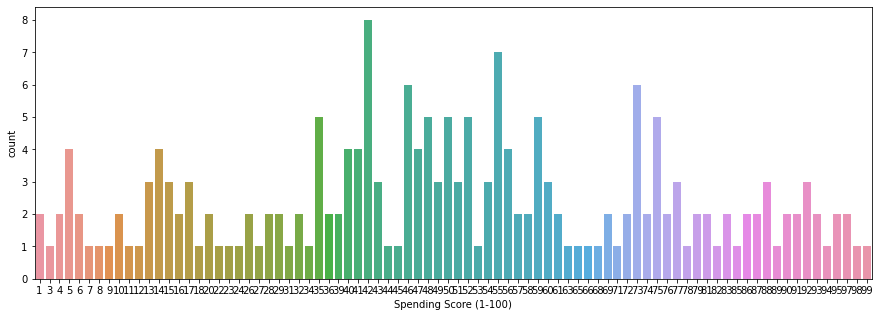

In [5]:
plt.figure(figsize=(15,5))
sns.countplot(customer_data["Spending Score (1-100)"])

It looks like Income, Spending, and Age are all fairly normally distributed.

Text(0.5, 0, 'Income')

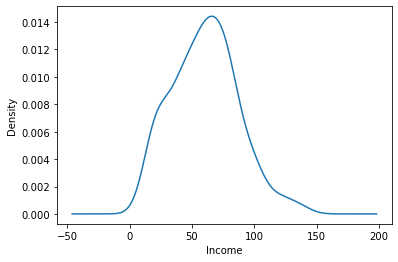

In [6]:
customer_data["Annual Income (k$)"].plot.density()
plt.xlabel("Income")

Text(0.5, 0, 'Spending Score')

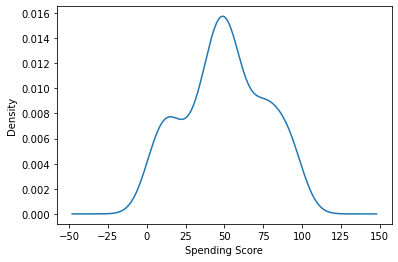

In [7]:
customer_data["Spending Score (1-100)"].plot.density()
plt.xlabel("Spending Score")

Text(0.5, 0, 'Age')

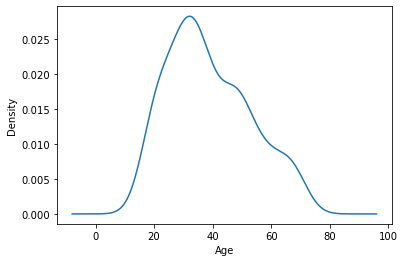

In [8]:
customer_data["Age"].plot.density()
plt.xlabel("Age")

Text(0.5, 0, 'Annual Income')

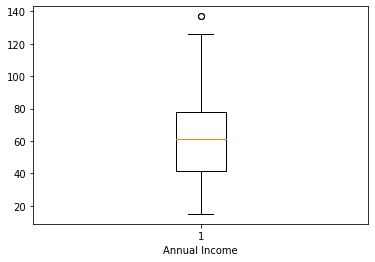

In [9]:
plt.boxplot(customer_data["Annual Income (k$)"])
plt.xlabel("Annual Income")

Text(0.5, 0, 'Spending Score')

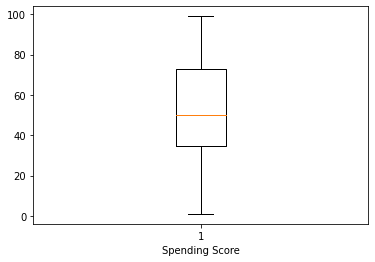

In [10]:
plt.boxplot(customer_data["Spending Score (1-100)"])
plt.xlabel("Spending Score")

In [11]:
X = customer_data[["Age", "Annual Income (k$)", "Spending Score (1-100)"]].to_numpy()

# Modeling


Now comes the fun part! We will use five functions to build the model and one more to determine how many centroids to use.

In [12]:
def init_centroids(K, data=X):
    '''Returns a random initialization of centroids for K-means process
    
    Parameters
    ------------
    K : int
        the number of centroids you want to return
    data : numpy.array
        the input data
    '''
    return np.random.permutation(data)[:K]

In [13]:
def plus_plus(K, data=X):
    '''Uses the K-means++ algorithm to initialize 
    the centroids far away from eachother
    
    Credit goes to user Steve Tjoa from https://stackoverflow.com/questions/5466323/how-could-one-implement-the-k-means-algorithm 
    for the Python implementation
    
    Parameters:
    -------------
    K : int
        the number of centroids you want to return
    data : numpy.array
        the input data
        
    Returns:
    -------------
    centroids : list of numpy arrays
        the initialized centroids
    '''
    centroids = [data[0]]
    for _ in range(1, K):
        dist_squared = np.array([min([np.inner(c-x, c-x) for c in centroids]) for x in data])
        probs = dist_squared / dist_squared.sum()
        cumprobs = probs.cumsum()
        r = np.random.rand()

        for (j, p) in enumerate(cumprobs):
            if r < p:
                i = j
                break
        centroids.append(data[i])
    return centroids

In [14]:
def find_closest_centroids(centroids, data=X):
    '''Assigns each sample to a centroid
    
    Parameters
    ------------
    centroids : list of numpy arrays
        the initialized centroids
    data : numpy.array
        the input data
        
    Returns
    ------------
    idx : numpy.array
        the assigned group of each centroid
    '''
    m = len(data)
    idx = np.zeros(m)
    K = len(centroids)
    for i in range(m):
        sample = data[i]
        min_dist = 4206969420
        for j in range(K):
            centroid = centroids[j]
            distance = np.linalg.norm(sample - centroid)
            if distance < min_dist:
                min_dist = distance
                idx[i] = j
    return idx

In [15]:
def compute_centroids(idx, data=X):
    '''Returns means of datapoints assigned to each centroid, sets this as new centroid
        
    Parameters
    ------------
    idx : numpy.array
        the assigned group of each centroid
    data : numpy.array
        the input data
    '''
    unique_centroids = np.unique(idx)
    centroid_means = [np.mean(data[idx == val], axis = 0) for val in unique_centroids]
    return np.array(centroid_means) 

In [16]:
def run_k_means(centroids, max_iters, data = X):
    idx = []
    for i in range(max_iters):
        idx = find_closest_centroids(centroids)
        centroids = compute_centroids(idx)
    return (centroids, idx)

In [24]:
#elbow method to determine how many clusters to use
def elbow_method(data=X):
    ''' This function uses the elbow method to determine how many clusters to segment the data into.
        It plots a graph of the mean distortions of each of the cluster numbers from 1 to 10
    
    Parameters
    ------------
    data : numpy.array
        the input data
    '''
    distortions = []
    k_list = list(range(1, 10))
    m = len(X)
    for k in k_list:
        centroids, idx = run_k_means(plus_plus(k), 50)
        distortions.append(np.sum(np.min(cdist(X, centroids, "euclidean"), axis = 1))/m) 
    plt.plot(k_list, distortions)
    plt.xlabel("# of Clusters")
    plt.ylabel("Distortions")

The Elbow Method is a good rule of thumb for determining how many clusters to segment your dataset into. The elbow_method function plots a graph of the **distortions** (the mean distances from each point in a cluster to the centroid of that cluster). At first, this distortion number falls rapidly but at some point there's an "elbow" on the graph where the distortion falls more slowly (in our case at 3 clusters!). We will select this "elbow" point as the number of clusters for our final output.

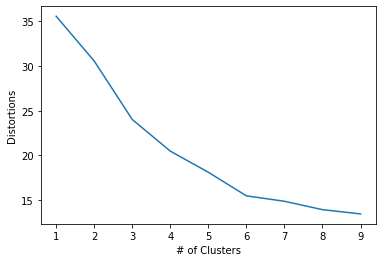

In [25]:
elbow_method(X)

Text(0.5, 0, 'Spending Score (1-100)')

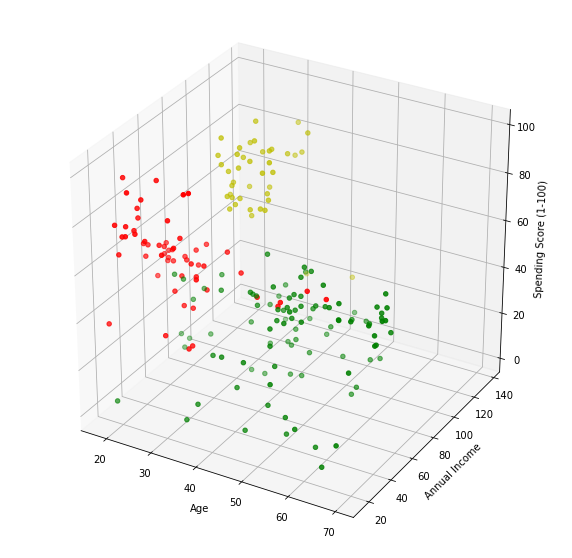

In [23]:
initial_centroids = plus_plus(3)
clusters, idx = run_k_means(initial_centroids, 100)
color_map = {i:color for (i, color) in zip(np.unique(idx), ['r', 'g', 'y', "purple", "turquoise", "blue"])}
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.scatter3D(customer_data["Age"], customer_data["Annual Income (k$)"], customer_data["Spending Score (1-100)"], c=[color_map[i] for i in idx])
ax.set_xlabel("Age")
ax.set_ylabel("Annual Income")
ax.set_zlabel("Spending Score (1-100)")

In [20]:
customer_data["Group"] = idx

And that's all! The KMeans algorithm seemed to segment the data into three pretty distinct clusters.